In [1]:
# Load Libraries
import pandas as pd
import os
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
from time import time
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors, metrics
from sklearn.metrics import confusion_matrix
import pylab as pl

In [2]:
pwd

'C:\\Users\\jleco\\OneDrive - Nexus365\\Data Science Projects\\02. Python Learning\\Free Agent Task'

In [3]:
# Load Data Labels
labels = pd.read_csv(r"bank_transaction_labels.csv")
labels.head()

,bank_transaction_id,bank_transaction_category,bank_transaction_dataset
0,21786195,TRAVEL,TRAIN
1,21786196,TRAVEL,TRAIN
2,21786197,TRAVEL,TRAIN
3,21786198,TRAVEL,TRAIN
4,21786199,TRAVEL,TRAIN


In [4]:
# Load Data Features
features = pd.read_csv(r"bank_transaction_features.csv")
features.head()

,bank_transaction_id,bank_transaction_description,bank_transaction_amount,bank_transaction_type
0,21786195,citylink,-13.80,MPO
1,21786196,citylink,-13.14,DEB
2,21786197,1Jul19 OYSTER,-36.98,DEB
3,21786198,travelodge,-75.73,MPO
4,21786199,6Jul19 RINGGO,-37.86,CSH


In [5]:
# Merge the two together based on transaction id
labels_features = pd.merge(labels,features,on='bank_transaction_id',how='outer')
labels_features.head()

,bank_transaction_id,bank_transaction_category,bank_transaction_dataset,bank_transaction_description,bank_transaction_amount,bank_transaction_type
0,21786195,TRAVEL,TRAIN,citylink,-13.80,MPO
1,21786196,TRAVEL,TRAIN,citylink,-13.14,DEB
2,21786197,TRAVEL,TRAIN,1Jul19 OYSTER,-36.98,DEB
3,21786198,TRAVEL,TRAIN,travelodge,-75.73,MPO
4,21786199,TRAVEL,TRAIN,6Jul19 RINGGO,-37.86,CSH


In [6]:
# Add length and first digit of the description as this might be a useful way to summarize statistically on the description
labels_features["desc_length"] = labels_features["bank_transaction_description"].str.len()
labels_features.head()


,bank_transaction_id,bank_transaction_category,bank_transaction_dataset,bank_transaction_description,bank_transaction_amount,bank_transaction_type,desc_length
0,21786195,TRAVEL,TRAIN,citylink,-13.80,MPO,8.0
1,21786196,TRAVEL,TRAIN,citylink,-13.14,DEB,8.0
2,21786197,TRAVEL,TRAIN,1Jul19 OYSTER,-36.98,DEB,13.0
3,21786198,TRAVEL,TRAIN,travelodge,-75.73,MPO,10.0
4,21786199,TRAVEL,TRAIN,6Jul19 RINGGO,-37.86,CSH,13.0


In [7]:
# Assess dimensionality of outer join to check no lost observations in join
labels.count()

bank_transaction_id          12500
bank_transaction_category    12500
bank_transaction_dataset     12500
dtype: int64

In [8]:
features.count()

bank_transaction_id             12500
bank_transaction_description    12369
bank_transaction_amount         12500
bank_transaction_type           12500
dtype: int64

In [9]:
labels_features.count()

bank_transaction_id             12500
bank_transaction_category       12500
bank_transaction_dataset        12500
bank_transaction_description    12369
bank_transaction_amount         12500
bank_transaction_type           12500
desc_length                     12369
dtype: int64

In [10]:
# Note a few transactions are missing descriptions.
# Need to deal with these at some point prior to modelling.
labels_features.isnull().values.any()

True

In [11]:
labels_features.isnull().sum().sum()

262

In [12]:
# All are NaNs and only column affected is the bank transaction description
labels_features['bank_transaction_description'].isnull().sum()

131

In [13]:
# Question 1: Exploratory Data Analysis
# How many transactions do we have of each type?
pd.crosstab(labels_features['bank_transaction_category'], "Count")

col_0,Count
bank_transaction_category,
ACCOMMODATION_AND_MEALS,3765
BANK_OR_FINANCE_CHARGES,2790
INSURANCE,1170
MOTOR_EXPENSES,1609
TRAVEL,3166


In [14]:
# Which types fall in which categories?
pd.crosstab(labels_features['bank_transaction_category'], labels_features["bank_transaction_type"])

bank_transaction_type,CHG,CSH,DD,DEB,FPO,MPO
bank_transaction_category,,,,,,
ACCOMMODATION_AND_MEALS,0,1112,0,1941,398,314
BANK_OR_FINANCE_CHARGES,2510,0,0,0,149,131
INSURANCE,0,0,940,0,111,119
MOTOR_EXPENSES,0,261,168,865,17,298
TRAVEL,0,668,0,1872,4,622


In [15]:
pd.crosstab(labels_features['bank_transaction_category'], labels_features["bank_transaction_type"], normalize = 'index')

bank_transaction_type,CHG,CSH,DD,DEB,FPO,MPO
bank_transaction_category,,,,,,
ACCOMMODATION_AND_MEALS,0.000000,0.295352,0.000000,0.515538,0.105710,0.083400
BANK_OR_FINANCE_CHARGES,0.899642,0.000000,0.000000,0.000000,0.053405,0.046953
INSURANCE,0.000000,0.000000,0.803419,0.000000,0.094872,0.101709
MOTOR_EXPENSES,0.000000,0.162213,0.104413,0.537601,0.010566,0.185208
TRAVEL,0.000000,0.210992,0.000000,0.591282,0.001263,0.196462


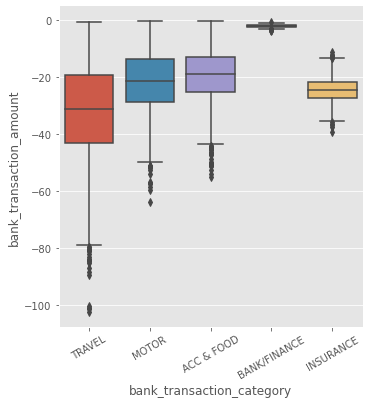

In [16]:
# What does the distribution of transaction amounts look like for each category?
dist_plot = sns.catplot(x="bank_transaction_category", y="bank_transaction_amount", kind='box',data=labels_features)
dist_plot.set_xticklabels(["TRAVEL", "MOTOR", "ACC & FOOD", "BANK/FINANCE", "INSURANCE"],rotation=30)

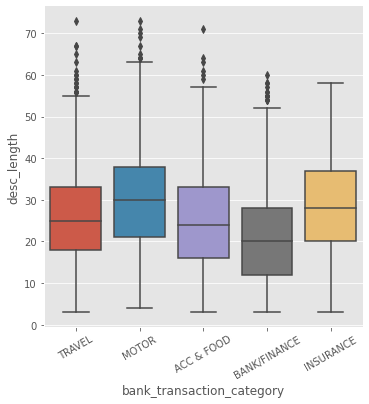

In [17]:
# What does the distribution of description lengths look like for each category?
dist_plot = sns.catplot(x="bank_transaction_category", y="desc_length", kind='box',data=labels_features)
dist_plot.set_xticklabels(["TRAVEL", "MOTOR", "ACC & FOOD", "BANK/FINANCE", "INSURANCE"],rotation=30)

In [18]:
# How different are these statistics when comparing by train / test split
pd.crosstab(labels_features['bank_transaction_dataset'], "Count")

col_0,Count
bank_transaction_dataset,
TRAIN,10000
VAL,2500


In [19]:
pd.crosstab(labels_features['bank_transaction_category'], labels_features['bank_transaction_dataset'])

bank_transaction_dataset,TRAIN,VAL
bank_transaction_category,,
ACCOMMODATION_AND_MEALS,3017,748
BANK_OR_FINANCE_CHARGES,2250,540
INSURANCE,920,250
MOTOR_EXPENSES,1235,374
TRAVEL,2578,588


In [20]:
pd.crosstab(labels_features['bank_transaction_category'], labels_features['bank_transaction_dataset'], normalize = 'index')

bank_transaction_dataset,TRAIN,VAL
bank_transaction_category,,
ACCOMMODATION_AND_MEALS,0.801328,0.198672
BANK_OR_FINANCE_CHARGES,0.806452,0.193548
INSURANCE,0.786325,0.213675
MOTOR_EXPENSES,0.767557,0.232443
TRAVEL,0.814277,0.185723


In [21]:
train = labels_features[labels_features['bank_transaction_dataset'] == "TRAIN"]
validation = labels_features[labels_features['bank_transaction_dataset'] == "VAL"]


In [22]:
pd.crosstab(train['bank_transaction_category'], train["bank_transaction_type"], normalize = 'index')

bank_transaction_type,CHG,CSH,DD,DEB,FPO,MPO
bank_transaction_category,,,,,,
ACCOMMODATION_AND_MEALS,0.000000,0.307259,0.000000,0.502486,0.101757,0.088499
BANK_OR_FINANCE_CHARGES,0.901778,0.000000,0.000000,0.000000,0.048889,0.049333
INSURANCE,0.000000,0.000000,0.802174,0.000000,0.096739,0.101087
MOTOR_EXPENSES,0.000000,0.165992,0.099595,0.548178,0.010526,0.175709
TRAVEL,0.000000,0.204810,0.000000,0.591156,0.001552,0.202483


In [23]:
pd.crosstab(validation['bank_transaction_category'], validation["bank_transaction_type"], normalize = 'index')

bank_transaction_type,CHG,CSH,DD,DEB,FPO,MPO
bank_transaction_category,,,,,,
ACCOMMODATION_AND_MEALS,0.000000,0.247326,0.000000,0.568182,0.121658,0.062834
BANK_OR_FINANCE_CHARGES,0.890741,0.000000,0.000000,0.000000,0.072222,0.037037
INSURANCE,0.000000,0.000000,0.808000,0.000000,0.088000,0.104000
MOTOR_EXPENSES,0.000000,0.149733,0.120321,0.502674,0.010695,0.216578
TRAVEL,0.000000,0.238095,0.000000,0.591837,0.000000,0.170068


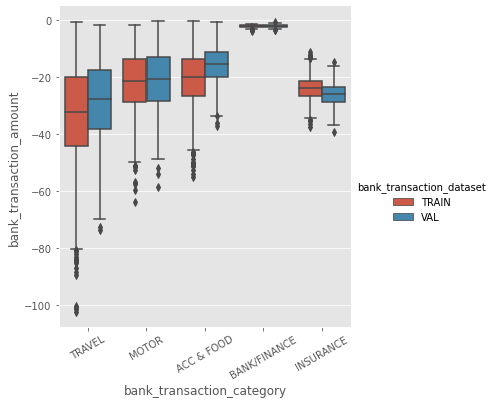

In [40]:
# What does the distribution of transaction amounts look like for each category? Split by TRAIN and VAL
dist_plot = sns.catplot(x="bank_transaction_category", y="bank_transaction_amount", 
                        hue="bank_transaction_dataset", kind='box', data=labels_features)
dist_plot.set_xticklabels(["TRAVEL", "MOTOR", "ACC & FOOD", "BANK/FINANCE", "INSURANCE"],rotation=30)

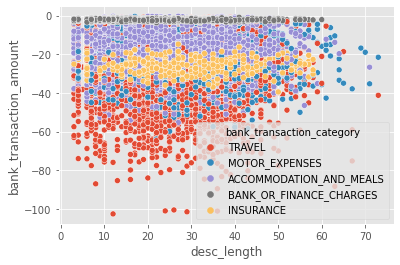

In [50]:
dist_plot = sns.scatterplot(x="desc_length", y="bank_transaction_amount", 
                        hue="bank_transaction_category", y_jitter=1,data=labels_features, legend='brief')

In [25]:
labels_features.head()

,bank_transaction_id,bank_transaction_category,bank_transaction_dataset,bank_transaction_description,bank_transaction_amount,bank_transaction_type,desc_length
0,21786195,TRAVEL,TRAIN,citylink,-13.80,MPO,8.0
1,21786196,TRAVEL,TRAIN,citylink,-13.14,DEB,8.0
2,21786197,TRAVEL,TRAIN,1Jul19 OYSTER,-36.98,DEB,13.0
3,21786198,TRAVEL,TRAIN,travelodge,-75.73,MPO,10.0
4,21786199,TRAVEL,TRAIN,6Jul19 RINGGO,-37.86,CSH,13.0


In [26]:
# Question 2 - Now start to build a transaction classification model
# Convert Bank Transaction Type
labels_features["bank_transaction_type"] = labels_features["bank_transaction_type"].astype('category')
labels_features.dtypes
labels_features["bank_transaction_type_code"] = labels_features["bank_transaction_type"].cat.codes
labels_features.head()


,bank_transaction_id,bank_transaction_category,bank_transaction_dataset,bank_transaction_description,bank_transaction_amount,bank_transaction_type,desc_length,bank_transaction_type_code
0,21786195,TRAVEL,TRAIN,citylink,-13.80,MPO,8.0,5
1,21786196,TRAVEL,TRAIN,citylink,-13.14,DEB,8.0,3
2,21786197,TRAVEL,TRAIN,1Jul19 OYSTER,-36.98,DEB,13.0,3
3,21786198,TRAVEL,TRAIN,travelodge,-75.73,MPO,10.0,5
4,21786199,TRAVEL,TRAIN,6Jul19 RINGGO,-37.86,CSH,13.0,1


In [27]:
labels_features.head()

,bank_transaction_id,bank_transaction_category,bank_transaction_dataset,bank_transaction_description,bank_transaction_amount,bank_transaction_type,desc_length,bank_transaction_type_code
0,21786195,TRAVEL,TRAIN,citylink,-13.80,MPO,8.0,5
1,21786196,TRAVEL,TRAIN,citylink,-13.14,DEB,8.0,3
2,21786197,TRAVEL,TRAIN,1Jul19 OYSTER,-36.98,DEB,13.0,3
3,21786198,TRAVEL,TRAIN,travelodge,-75.73,MPO,10.0,5
4,21786199,TRAVEL,TRAIN,6Jul19 RINGGO,-37.86,CSH,13.0,1


In [28]:
# Drop NaNs - investigated above and very small proportion
labels_features = labels_features.dropna()

In [29]:
# Split into features and labels, train and validation sets
# Structure: we have 3 features: "bank_transaction_amount", "desc_length", "bank_transaction_type"
#            all will be used to predict "bank_transaction_category"
y_train = labels_features["bank_transaction_category"][labels_features["bank_transaction_dataset"]=="TRAIN"]
X_train = labels_features.filter(items=["bank_transaction_amount", "desc_length", "bank_transaction_type_code"])[labels_features["bank_transaction_dataset"]=="TRAIN"]


In [30]:
y_train

0          TRAVEL
1          TRAVEL
2          TRAVEL
3          TRAVEL
4          TRAVEL
          ...    
9995    INSURANCE
9996    INSURANCE
9997    INSURANCE
9998    INSURANCE
9999    INSURANCE
Name: bank_transaction_category, Length: 9891, dtype: object

In [31]:
X_train

,bank_transaction_amount,desc_length,bank_transaction_type_code
0,-13.80,8.0,5
1,-13.14,8.0,3
2,-36.98,13.0,3
3,-75.73,10.0,5
4,-37.86,13.0,1
...,...,...,...
9995,-23.50,27.0,2
9996,-25.75,37.0,2
9997,-25.76,24.0,2
9998,-21.21,24.0,5


In [32]:
y_test = labels_features["bank_transaction_category"][labels_features["bank_transaction_dataset"]=="VAL"]
X_test = labels_features.filter(items=["bank_transaction_amount", "desc_length", "bank_transaction_type_code"])[labels_features["bank_transaction_dataset"]=="VAL"]


In [33]:
y_test

10000       TRAVEL
10001       TRAVEL
10002       TRAVEL
10003       TRAVEL
10004       TRAVEL
           ...    
12495    INSURANCE
12496    INSURANCE
12497    INSURANCE
12498    INSURANCE
12499    INSURANCE
Name: bank_transaction_category, Length: 2478, dtype: object

In [34]:
X_test

,bank_transaction_amount,desc_length,bank_transaction_type_code
10000,-12.70,20.0,3
10001,-24.49,7.0,3
10002,-38.81,19.0,3
10003,-32.75,8.0,3
10004,-21.10,60.0,1
...,...,...,...
12495,-28.46,9.0,4
12496,-35.64,34.0,4
12497,-22.37,35.0,2
12498,-23.11,30.0,2


In [35]:
# Initialise the SVM Model
model_svm = svm.SVC()
model_svm.fit(X_train,y_train)

SVC()

In [36]:
# Run predictions and some metrics
prediction_svm = model_svm.predict(X_test)
acc_svm = accuracy_score(y_test, prediction_svm)
cm = confusion_matrix(y_test, prediction_svm)

In [37]:
# Print Some stats
print("SVM accuracy: ", acc_svm)

SVM accuracy:  0.579499596448749


<ipython-input-38-e975ccc33c0d>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels, rotation=45)
<ipython-input-38-e975ccc33c0d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels, rotation=30)


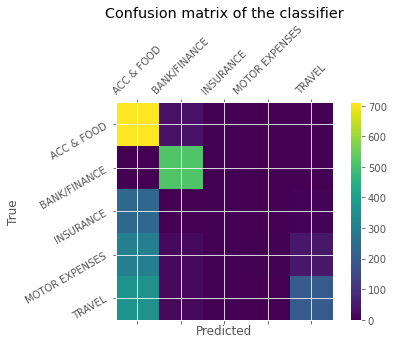

In [38]:
labels = ["ACC & FOOD","BANK/FINANCE", "INSURANCE","MOTOR EXPENSES", "TRAVEL"]
cm = confusion_matrix(y_test, prediction_svm)
fig = plt.figure() 
ax = fig.add_subplot(111) 
cax = ax.matshow(cm) 
plt.title('Confusion matrix of the classifier') 
fig.colorbar(cax) 
ax.set_xticklabels([''] + labels, rotation=45) 
ax.set_yticklabels([''] + labels, rotation=30) 
plt.xlabel('Predicted') 
plt.ylabel('True') 
plt.show()

In [39]:
print(cm)

[[711  34   0   1   2]
 [  0 518   0   0   0]
 [241   0   0   1   8]
 [307  18   0   3  46]
 [366  18   0   0 204]]
